In [1]:
import torch

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [4]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

In [5]:
# install for train and test
root = './'
train = MNIST(root, train=True, transform=data_tfs, download=True)
test = MNIST(root, train=False, transform=data_tfs, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9913344it [00:01, 4961133.62it/s]                             


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



29696it [00:00, 30430992.32it/s]         


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

1649664it [00:00, 2543592.53it/s]                             


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



5120it [00:00, 5116711.10it/s]          

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw




C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [7]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [8]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
features = 784
classes = 10

In [10]:
W = torch.FloatTensor(features, classes).uniform_(-1, 1) / features**0.5
W.requires_grad_()

tensor([[-0.0021,  0.0065, -0.0045,  ...,  0.0290,  0.0250, -0.0089],
        [-0.0136,  0.0057, -0.0267,  ..., -0.0246,  0.0067,  0.0310],
        [ 0.0121,  0.0304,  0.0146,  ...,  0.0348,  0.0132,  0.0147],
        ...,
        [ 0.0150,  0.0105, -0.0229,  ...,  0.0203, -0.0172,  0.0325],
        [-0.0346,  0.0168,  0.0029,  ...,  0.0014,  0.0333, -0.0167],
        [-0.0149, -0.0303, -0.0137,  ..., -0.0057,  0.0303, -0.0276]],
       requires_grad=True)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
epochs = 3
lr = 1e-2
history = []

In [13]:
import numpy as np
from torch.nn.functional import cross_entropy

In [14]:
for i in range(epochs):
    for x_batch, y_batch in train_loader:
        # load batches of data correctly
        x_batch = x_batch.reshape(x_batch.shape[0], -1)
        y_batch = y_batch

        # compute loss (log loss a.k.a. cross entropy)
        logits = x_batch @ W
        probabilities = torch.exp(logits) / torch.exp(logits).sum(dim=1, keepdim=True)

        loss = -torch.log(probabilities[range(batch_size), y_batch]).mean()
        history.append(loss.item())

        # calc gradients
        loss.backward()

        # step of gradient descent
        grad = W.grad
        with torch.no_grad():
            W -= lr * grad
        W.grad.zero_()

    print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.19382932782173157
2,	 loss: 0.1398342251777649
3,	 loss: 0.12010495364665985


In [15]:
import matplotlib.pyplot as plt

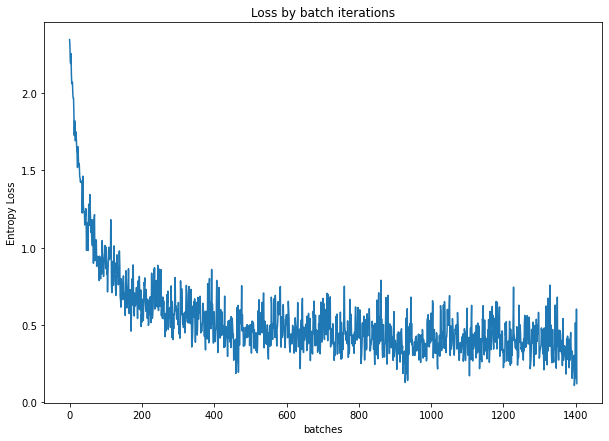

In [16]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [17]:
from sklearn.metrics import accuracy_score

In [19]:
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
    # load batches of data correctly
    batches += 1
    x_batch = x_batch.view(x_batch.shape[0], -1)
    y_batch = y_batch

    preds = torch.argmax(x_batch @ W, dim=1)
    acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.901
